In [18]:
import cv2
import joblib
import pandas as pd 
import numpy as np
import albumentations as A
from time import time
from random import seed
from tensorflow import keras 
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.vis_utils import plot_model
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
import matplotlib.pyplot as plt

In [19]:
DATA_PATH = './data'
def load_dataset():
    X_yes = np.load(f'{DATA_PATH}/def_yes_images.npy')
    X_no = np.load(f'{DATA_PATH}/def_no_images.npy')
    classes = np.load(f'{DATA_PATH}/classes.npy')

    print(f'X_yes shape: {X_yes.shape}')
    print(f'X_no shape {X_no.shape}')
    print(f'classes shape: {classes.shape}')

    return X_yes, X_no, classes

def reshape_dataset(X_yes, X_no):
    X = np.row_stack((X_yes, X_no))
    N, SIZE_H, SIZE_V = X.shape
    X = np.reshape(X, newshape=(N, SIZE_H * SIZE_V))
    print(f'X shape: {X.shape}')
    return X

def data_augmentation(imgs, aug_per_image, imgs_trans):
    new_images = []
    for img, i in zip(imgs, range(1, len(imgs) + 1)):
        for _ in range(aug_per_image):
            tmp_img = imgs_trans(image=img)["image"]
            new_images.append(tmp_img)
        if i % 50 == 0: print(f'[!] {i} images agumented...')
    print(f'[!] Total of {len(imgs)} images augmented!\n')
    return new_images

In [20]:
X_yes, X_no, classes = load_dataset()
X = np.row_stack((X_yes, X_no))
N, SIZE_H, SIZE_V = X.shape
N_CLASSES = len(np.unique(classes))
print(f'X shape {X.shape}')

X_yes shape: (134, 224, 224)
X_no shape (86, 224, 224)
classes shape: (220,)
X shape (220, 224, 224)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 112, 112, 32)      832       
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 109, 109, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 109, 109, 64)      51264     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 186624)            0         
                                                                 
 dense_42 (Dense)            (None, 120)             

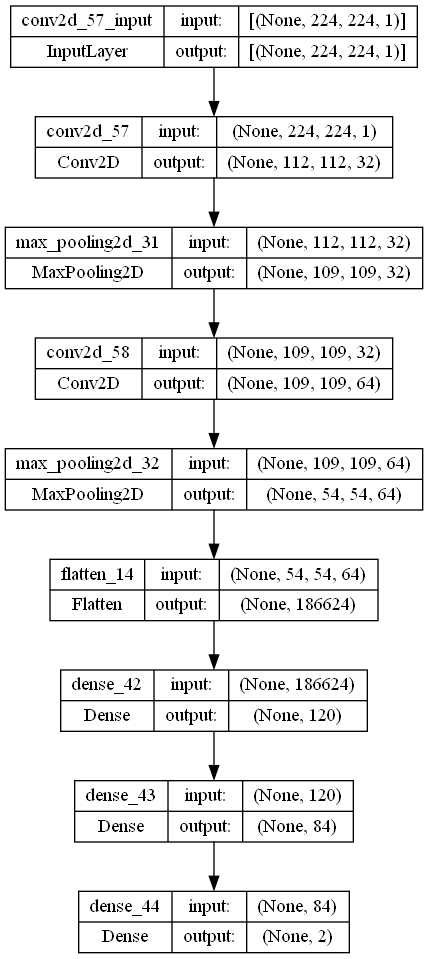

In [21]:
le_net_5 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(5, 5), strides=2, padding="same", input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    MaxPooling2D(pool_size=(4, 4), strides=1, padding="valid"),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(5, 5), strides=1, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2, padding="valid"),
    # FLATTEN
    Flatten(),
    # DENSE LAYERS
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    # OUTPUT
    Dense(units=N_CLASSES, activation='softmax')
])

print(le_net_5.summary())
plot_model(le_net_5, show_shapes=True, show_layer_names=True)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 conv2d_60 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_62 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                

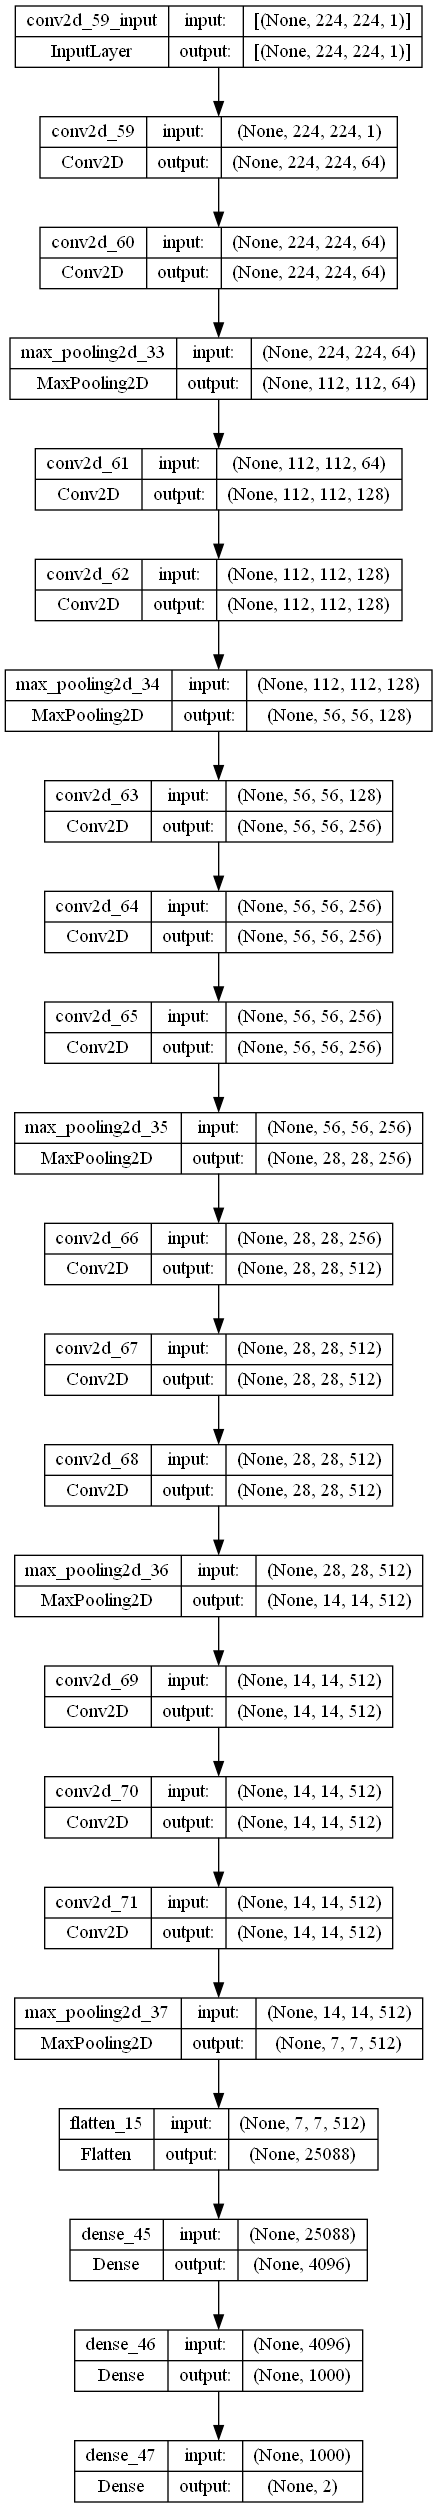

In [22]:
vgg_16 = keras.Sequential([
    # LAYER 1
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 2
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 3
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 4
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # LAYER 5
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Conv2D(filters=512, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    # MAXPOOL BEFORE FC
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # FULLY CONNECTED LAYERS
    Flatten(),
    Dense(units=4096, activation='relu'),
    Dense(units=1000, activation='relu'),
    # OUTPUT LAYER
    Dense(units=N_CLASSES, activation='softmax')
])

print(vgg_16.summary())
plot_model(vgg_16, show_shapes=True, show_layer_names=True)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 224, 224, 32)      320       
                                                                 
 conv2d_73 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_75 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                

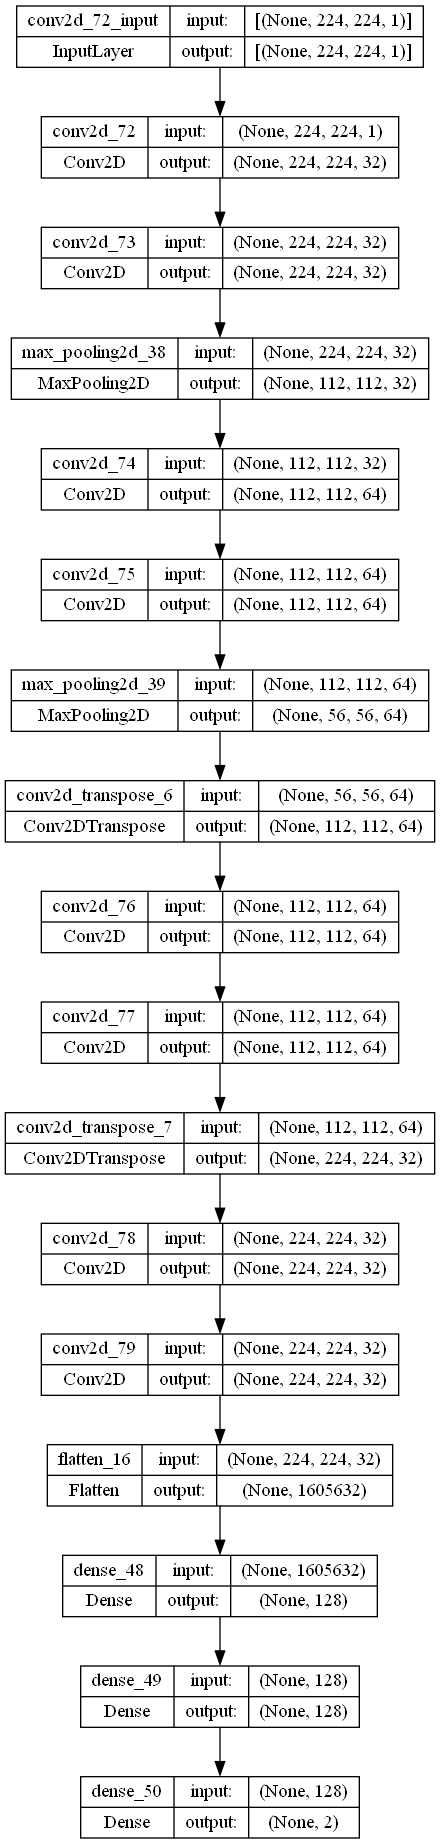

In [23]:
lu_net = keras.Sequential([
    # LAYER 1
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', input_shape=(SIZE_H, SIZE_V, 1), activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 2
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    # LAYER 3
    Conv2DTranspose(filters=64, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # LAYER 4
    Conv2DTranspose(filters=32, kernel_size=(2, 2), strides=2, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding='same', activation='elu'),
    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='sigmoid'),
    Dense(units=128, activation='sigmoid'),
    # OUTPUT
    Dense(units=N_CLASSES, activation='sigmoid')
])

print(lu_net.summary())
plot_model(lu_net, show_shapes=True, show_layer_names=True)

In [ ]:
le_net_5.compile(optimizer='adam', loss='binary_crossentropy', metrics='balanced_accuracy')
vgg_16.compile(optimizer='adam', loss='binary_crossentropy', metrics='balanced_accuracy')
lu_net.compile(optimizer='adam', loss='binary_crossentropy', metrics='balanced_accuracy')

In [ ]:
le_net_5_k = KerasClassifier(le_net_5)
vgg_16_k = KerasClassifier(vgg_16)
lu_net_k = KerasClassifier(lu_net)

sd = seed(time())
RSKFold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=sd)

In [ ]:
res_le_net = cross_val_score(le_net_5_k, X, classes, cv=RSKFold, n_jobs=-1)

In [ ]:
RES_FILE_NAME_1 = 'le_net_results.pkl'
joblib.dumps(res_le_net, RES_FILE_NAME_1)

In [ ]:
res_vgg_16 = cross_val_score(vgg_16_k, X, classes, cv=RSKFold, n_jobs=-1)

In [ ]:
RES_FILE_NAME_2 = 'vgg_16_results.pkl'
joblib.dumps(res_vgg_16, RES_FILE_NAME_2)

In [ ]:
res_lu_net = cross_val_score(lu_net_k, X, classes, cv=RSKFold, n_jobs=-1)

In [ ]:
RES_FILE_NAME_3 = 'lu_net_results.pkl'
joblib.dumps(res_lu_net, RES_FILE_NAME_3)